This is the second version of this notebook, that includes visualisation and feature engineering, as well as testing different models. So far, I have achieved an accuracy of 79.425%.

You can find more information and how I slowly improved my accuracy to arrive at this code by reading my blog: https://celineterranova.com/blog/

# 1. Load and Import

Importing the packages that I need:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

import seaborn as sns
from matplotlib import pyplot as plt
import pylab as plot

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


Loading the csv files:

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# 2. Data Description

First, checking how the data looks like in both files.

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Each row represents a passenger, for which we have various information:

* PassengerId: the ID number given for each passenger in this dataset. You can see it as the row number.
* Survived: 0 if they died, 1 if they survived.
* Pclass: whether they were in 1st, 2nd or 3rd class.
* Name: full name including title and sometimes maiden name.
* Sex: male or female
* Age: in years
* Sibsp: number of siblings and/or spouses aboard the Titanic
* Parch: number of parents and/or children aboard the Titanic
* Ticket: the ticket number
* Fare: how much they paid for their ticket
* Cabin: the cabin number
* Embarked: which port they embarked from. C = Cherbourg, Q = Queenstown, S = Southampton.

The testing data’s layout is exactly the same, without the “Survived” column.

There are 891 rows in the training data, meaning 891 passengers. With a very quick describe() function, I can get some statistical information about this data:

In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Immediately we notice something interesting in the “count” row: the number for Age is lower, which means that, for some passengers, no age is present in the table. Note that this information only took in account the column that had numbers in them, not strings (which makes sense), so we have blanks in other columns too (especially in the “cabin” column).

If we do the same work for the test data:

In [6]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


We also have missing information in the "age" column, as well as in the "fare" one.

# 3. Data Visualisation

In this section, I will plot some of the parameters that have an influence on the outcome (for the training data). For each feature, I will plot those who survived vs those who died.

First I'm choosing some parameters that will be used in the plots below (optional) and I'm adding a column "Died" to my dataset to make life easier.

In [7]:
params = {
    'axes.labelsize': "large",
    'xtick.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'legend.loc': "best",

}
plot.rcParams.update(params)

train_data['Died'] = 1 - train_data['Survived']

# *3a. Sex*

Let's plot the survival rate for men and women:

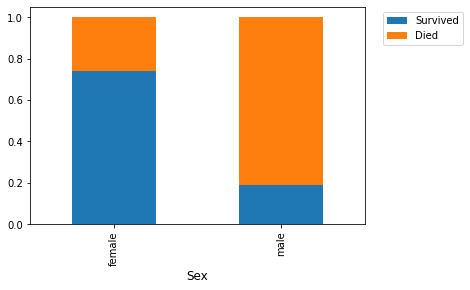

In [8]:
train_data.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

As you can see, women had almost 3 times more chances to survive the Titanic than men. This correlation is so strong that if you just use this parameter to predict who dies and who survives in your test sample, you would be 76.55% correct!

# *3b. Pclass*

Class also plays a role: people in first class had more chances to survive than those in second and third class. Plotted (relatively to the number of passengers in each class):

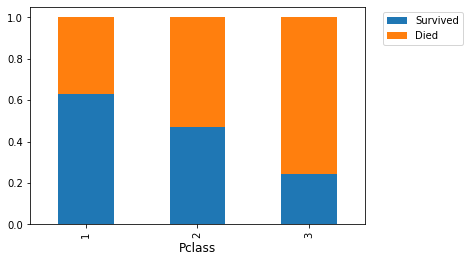

In [9]:
train_data.groupby('Pclass').agg('mean')[['Survived', 'Died']].plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# *3c. SibSp*

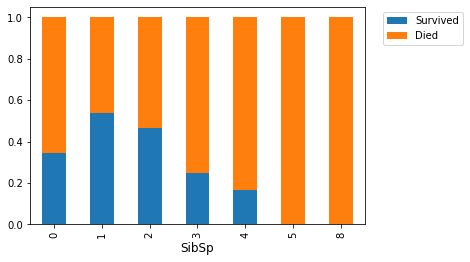

In [10]:
train_data.groupby('SibSp').agg('mean')[['Survived', 'Died']].plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# *3d. ParCh*

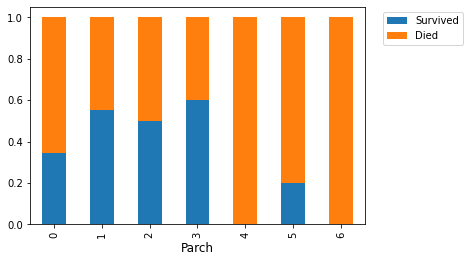

In [11]:
train_data.groupby('Parch').agg('mean')[['Survived', 'Died']].plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# *3e. Fare*

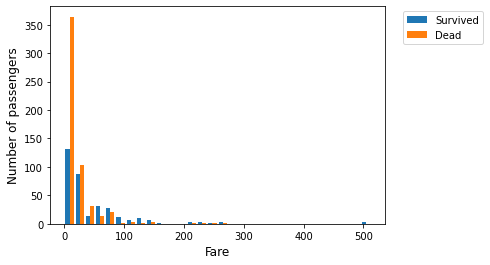

In [12]:
plt.hist([train_data[train_data['Survived'] == 1]['Fare'], train_data[train_data['Survived'] == 0]['Fare']], bins = 30, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# *3f. Fare*

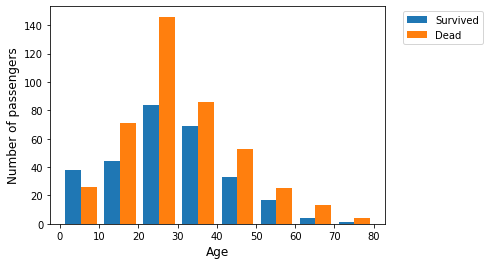

In [13]:
plt.hist([train_data[train_data['Survived'] == 1]['Age'], train_data[train_data['Survived'] == 0]['Age']], bins = 8, label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# 4. Feature Engineering

# *4a. Titles*

From the name field in the dataset, I can extract the title of the person. Let's first check what titles I have in both the training and the testing data:

In [14]:
sing_titles = list()
for name in train_data["Name"]:
    title = name.split(',')[1].split('.')[0].strip()
    if title not in sing_titles: sing_titles.append(title)
print(sing_titles)
sing_test = list()
for name in test_data["Name"]:
    title = name.split(',')[1].split('.')[0].strip()
    if title not in sing_test: sing_test.append(title)
print(sing_test)

['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer']
['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona']


I decided to divide these into 5 categories: Miss, Mrs, Mr, Noble, Crew.

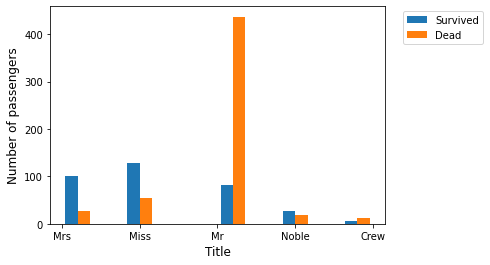

In [15]:
# Function that, given a title string, checks it and replaces it with the correct title
def title_corr(t):
    newt = t
    if t == 'Mrs' or t == 'Mr' or t == 'Miss':
        return newt
    elif t == 'Capt' or t == 'Col' or t == 'Major' or t == 'Dr' or t == 'Rev':
        newt = 'Crew'
    elif t == 'Jonkheer' or t == 'Sir' or t == 'the Countess' or t == 'Lady' or t == 'Master':
        newt = 'Noble'
    elif t == 'Don':
        newt = 'Mr'
    elif t == 'Dona' or t == 'Ms' or t == 'Mme':
        newt = 'Mrs'
    elif t == 'Mlle':
        newt = 'Miss'
    else: print("Title not included:", t)
    return newt

# Extract the titles from the name and put them in a list, then correct them
# Train data
titles = list()
for name in train_data["Name"]:
    titles.append(name.split(',')[1].split('.')[0].strip())
for i in range(len(titles)):
    titles[i] = title_corr(titles[i])
train_data["Titles"] = titles

# Plotting
plt.hist([train_data[train_data['Survived'] == 1]['Titles'], train_data[train_data['Survived'] == 0]['Titles']], label = ['Survived','Dead'])
plt.xlabel('Title')
plt.ylabel('Number of passengers')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# Test data
test_titles = list()
for name in test_data["Name"]:
    test_titles.append(name.split(',')[1].split('.')[0].strip())
for i in range(len(test_titles)):
    test_titles[i] = title_corr(test_titles[i])
test_data["Titles"] = test_titles

Mapping the titles depending on survival rate:

In [16]:
title_mapping = {"Mrs": 4, "Miss": 3, "Mr": 0, "Noble": 2,"Crew": 1}
train_data['Title Map'] = train_data['Titles'].map(title_mapping)
test_data['Title Map'] = test_data['Titles'].map(title_mapping)

# *4b. Fare Groups*

Fill the missing fares with the median:

In [17]:
train_data["Fare"] = train_data["Fare"].fillna(train_data["Fare"].median())
test_data["Fare"] = test_data["Fare"].fillna(test_data["Fare"].median())

As fare is a continuous parameters, we will benefit from grouping it:

In [18]:
train_data['FareGroup'] = pd.cut(train_data['Fare'],3)
print(train_data[['FareGroup', 'Survived']].groupby('FareGroup', as_index=False).mean().sort_values('Survived', ascending=False))

            FareGroup  Survived
2  (341.553, 512.329]  1.000000
1  (170.776, 341.553]  0.647059
0   (-0.512, 170.776]  0.376579


Group fares into 3 categories, weighed according to the survival rate:

In [19]:
def group_fare(fare):
    if fare <= 170: return 0
    if fare > 170 and fare <= 340: return 1
    if fare > 340: return 2
    
# Loops over the df and fill the Fare Group column
for i, row in train_data.iterrows():
    train_data.at[i,'Fare Group'] = group_fare(row["Fare"])
# Same for test data
for i, row in test_data.iterrows():
    test_data.at[i,'Fare Group'] = group_fare(row["Fare"])

# *4c. Age Groups*

First, let's fill the missing ages using a median for a specific sex, title and class for the whole dataset:

In [20]:
# Function that returns the median age for passengers from a certain class, sex and title
def calc_age(df, cl, sx, tl):
    a = df.groupby(["Pclass", "Sex", "Titles"])["Age"].median()
    return a[cl][sx][tl]

# Getting the full dataset (more accurate for median calculation)
age_train = train_data.copy()
age_train.drop('PassengerId', axis=1, inplace=True)
age_train.drop('Survived',axis=1, inplace=True)
age_test = test_data.copy()
age_test.drop('PassengerId', axis=1, inplace=True)
df = pd.concat([age_train, age_test], sort=False).reset_index(drop=True)

# Fill up missing ages
for i, row in train_data.iterrows():
    if pd.isna(row['Age']) :
        newage = (calc_age(df, row["Pclass"], row["Sex"], row["Titles"]))
        train_data.at[i,'Age'] = newage
    else: continue
# Same for test data
for i, row in test_data.iterrows():
    if pd.isna(row['Age']) :
        newage = (calc_age(df, row["Pclass"], row["Sex"], row["Titles"]))
        test_data.at[i,'Age'] = newage
    else: continue

Then, we want to group the ages:

In [21]:
train_data['AgeGroup'] = pd.cut(train_data['Age'],5)
print(train_data[['AgeGroup', 'Survived']].groupby('AgeGroup', as_index=False).mean().sort_values('Survived', ascending=False))

           AgeGroup  Survived
0    (0.34, 16.336]  0.548077
3  (48.168, 64.084]  0.428571
2  (32.252, 48.168]  0.412037
1  (16.336, 32.252]  0.336735
4    (64.084, 80.0]  0.090909


We will group the ages in 5 groups, weighed according to the survival rate:

In [22]:
def group_age(age):
    if age <= 16: return 4
    if age > 16 and age <= 32: return 1
    if age > 32 and age <= 48: return 2
    if age > 48 and age <= 64: return 3
    if age > 64: return 0

# Loops over the df and fill the Age Group column
for i, row in train_data.iterrows():
    train_data.at[i,'Age Group'] = group_age(row["Age"])
    # Same for test data
for i, row in test_data.iterrows():
    test_data.at[i,'Age Group'] = group_age(row["Age"])

# *4d. Family*

We want to use both SibSp and ParCh into one variable:

In [23]:
train_data["Family"] = train_data["SibSp"] + train_data["Parch"]
test_data["Family"] = test_data["SibSp"] + test_data["Parch"]

# *4e. Embarked*

Fill missing data for embarked feature:

In [24]:
train_data["Embarked"] = train_data["Embarked"].fillna('S')

Check out the survival rate for each port:

In [25]:
print(train_data[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean().sort_values('Survived', ascending=False))

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


Weigh the embarked feature with the survival rate into a new column:

In [26]:
def embarked_rate(embarked_port):
    if embarked_port == 'C': return 2
    if embarked_port == 'Q': return 1
    if embarked_port == 'S': return 0

for i, row in train_data.iterrows():
    train_data.at[i,'Emb Rate'] = embarked_rate(row["Embarked"])
for i, row in test_data.iterrows():
    test_data.at[i,'Emb Rate'] = embarked_rate(row["Embarked"])

# *4f. Sex Mapping*

In [27]:
sex_mapping = {"male": 0, "female": 1}
train_data['Sex Map'] = train_data['Sex'].map(sex_mapping)
test_data['Sex Map'] = test_data['Sex'].map(sex_mapping)

# 5. Model, Fit and Predict

Choose the features that will be used:

In [28]:
# Drops some columns
cols_to_drop = ["SibSp", "Parch", "Name", "Age", "Fare",  "Embarked", "Cabin", "Ticket", "Sex", "Titles"]
new_train = train_data.drop(cols_to_drop, axis=1)
new_test = test_data.drop(cols_to_drop, axis=1)

y = train_data["Survived"]
features = ["Pclass", "Sex Map", "Family", "Title Map", "Age Group", "Fare Group", "Emb Rate"]
X = pd.get_dummies(new_train[features])
X_test = pd.get_dummies(new_test[features])

Use different models to predict y:

In [29]:
model1 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model1.fit(X, y)
y1_test = model1.predict(X_test)

model2 = XGBClassifier(max_depth=3, n_estimators=1000, learning_rate=0.05)
model2.fit(X, y)
y2_test = model2.predict(X_test)

model3 = SVC(random_state=1)
model3.fit(X,y)
y3_test = model3.predict(X_test)

model4 = GradientBoostingClassifier(random_state=42)
model4.fit(X, y)
y4_test = model4.predict(X_test)

Calculate accuracy of each model:

In [30]:
model1_preds = cross_val_predict(model1, X, y, cv=10)
model1_acc = accuracy_score(y, model1_preds)
model2_preds = cross_val_predict(model2, X, y, cv=10)
model2_acc = accuracy_score(y, model2_preds)
model3_preds = cross_val_predict(model3, X, y, cv=10)
model3_acc = accuracy_score(y, model3_preds)
model4_preds = cross_val_predict(model4, X, y, cv=10)
model4_acc = accuracy_score(y, model4_preds)

print("Random Forest Accuracy:", model1_acc)
print("XGBoost Accuracy:", model2_acc)
print("SVC Accuracy:", model3_acc)
print("GB Accuracy:", model4_acc)

Random Forest Accuracy: 0.8327721661054994
XGBoost Accuracy: 0.8271604938271605
SVC Accuracy: 0.8327721661054994
GB Accuracy: 0.8215488215488216


Create output:

In [31]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y2_test})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
